In [54]:
import requests
from ultralytics.utils.plotting import Annotator
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imutils
from IPython.display import Image, display

In [55]:
class Camera:
    def __init__(self, name, lat, lon, image_url, video_url, img_timestamp, video_timestamp):
        self.name = name
        self.lat = lat
        self.lon = lon
        self.image_url = image_url
        self.video_url = video_url
        self.img_timestamp = img_timestamp
        self.video_timestamp = video_timestamp
        
    def __repr__(self):
        return f"{self.name}: ({self.lat}/{self.lon})"

In [56]:
def all_jam_cams():
    r = requests.get("https://api.tfl.gov.uk/Place/Type/JamCam")
    cams = []
    
    for cam in r.json():
        name = cam['commonName']
        lat = cam['lat']
        lon = cam['lon']
        image_url = None
        image_ts = None
        video_url = None
        video_ts = None
        
        properties = cam['additionalProperties']
        for prop in properties:
            if prop['key'] == 'imageUrl':
                image_url = prop['value']
                image_ts = prop['modified']
            elif prop['key'] == 'videoUrl':
                video_url = prop['value']
                video_ts = prop['modified']
        cams.append(
            Camera(name, lat, lon, image_url, video_url, image_ts, video_ts)
        )
    return cams

In [57]:
def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

In [5]:
# read class names from text file
classes = None
with open('yolo/yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

vehicles = ['car', 'motorcycle', 'bus', 'truck']
vehicle_ids = [2, 3, 5, 7]

net = cv2.dnn.readNet('yolo/yolov3.weights', 'yolo/yolov3.cfg')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV) # can I use a gpu here?

def count_vehicles(img_url):
    # create image from url
    image = imutils.url_to_image(cam.image_url)
    
    # create input blob 
    blob = cv2.dnn.blobFromImage(image, scale, (Width,Height), swapRB=True, crop=False)

    # determine the output layer
    ln = net.getLayerNames()
    ln = [ln[i-1] for i in net.getUnconnectedOutLayers()]

    # compute outputs
    net.setInput(blob)
    outputs = net.forward(ln)
    
    boxes = []
    confidences = []
    classIDs = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if confidence > 0.5:
                box = detection[:4] * np.array([Width, Height, Width, Height])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                box = [x, y, int(width), int(height)]
                boxes.append(box)
                confidences.append(float(confidence))
                classIDs.append(classID)
    
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    count = 0
    if len(indices) > 0:
        for i in indices.flatten():
            if classes[classIDs[i]] in vehicles:
                count += 1
    
    return count

In [6]:
cams = all_jam_cams()

In [7]:
len(cams)

905

In [8]:
cams[4].img_timestamp

'2023-10-25T11:49:36.143Z'

### Try to count vehicles

https://medium.com/analytics-vidhya/moving-car-detection-from-video-by-using-computer-vision-e285db894249
https://opencv-tutorial.readthedocs.io/en/latest/yolo/yolo.html

In [9]:
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

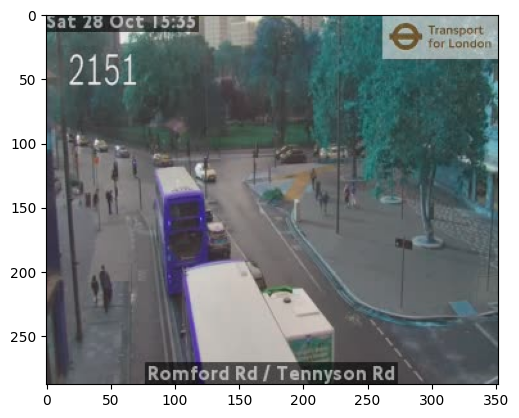

In [10]:
cam = cams[1]

image = imutils.url_to_image(cam.image_url)
plt.imshow(image)

In [11]:
Width = image.shape[1]
Height = image.shape[0]
scale = 1/255 # scale pixel values to [0,1]

# read class names from text file
classes = None
with open('yolo/yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# generate different colors for different classes
colors = np.random.uniform(0, 255, size=(len(classes), 3))
net = cv2.dnn.readNet('yolo/yolov3.weights', 'yolo/yolov3.cfg')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV) # can I use a gpu here?

# create input blob 
#blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)
blob = cv2.dnn.blobFromImage(image, scale, (Width,Height), swapRB=True, crop=False)

# determine the output layer
ln = net.getLayerNames()
ln = [ln[i-1] for i in net.getUnconnectedOutLayers()]

net.setInput(blob)
outputs = net.forward(ln)

In [13]:
boxes = []
confidences = []
classIDs = []

for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.5:
            box = detection[:4] * np.array([Width, Height, Width, Height])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

10


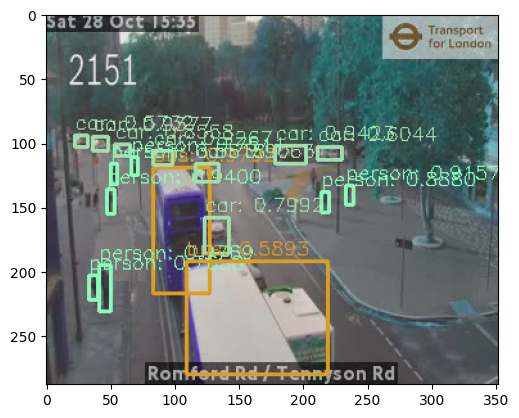

In [14]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
vehicles = ['car', 'motorcycle', 'bus', 'truck']
vehicle_ids = [2, 3, 5, 7]
count = 0

if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        
        if classes[classIDs[i]] in vehicles:
            count += 1
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

print(count)
plt.imshow(image)

In [15]:
count_vehicles(cam.image_url)

10

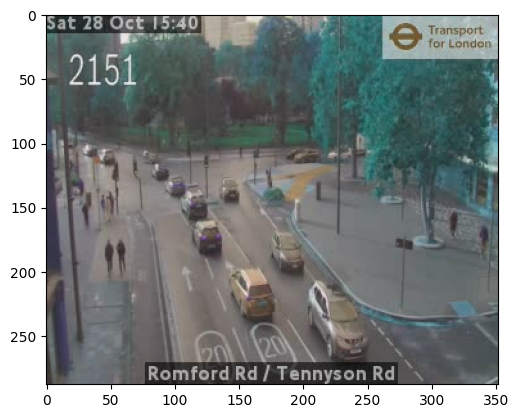

In [16]:
cam = cams[1]

image = imutils.url_to_image(cam.image_url)
plt.imshow(image)

In [18]:
model = YOLO('yolov8n.pt')  # pretrained YOLOv8n model

In [24]:
results = model.predict(cams[1].image_url, save=False)
result = results[0]


Found https://s3-eu-west-1.amazonaws.com/jamcams.tfl.gov.uk/00001.02151.jpg locally at 00001.02151.jpg
image 1/1 /home/tkbischoff/Documents/uni/master/UrbanTechnologies/00001.02151.jpg: 544x640 4 persons, 12 cars, 1 truck, 1 traffic light, 662.7ms
Speed: 35.2ms preprocess, 662.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


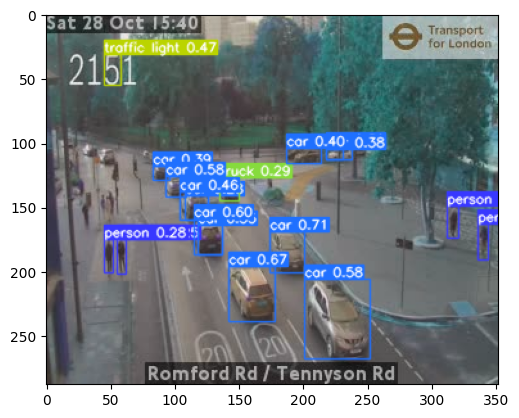

In [28]:
res_img = result.plot(line_width=1)
plt.imshow(res_img)

In [50]:
box = result.boxes[0]
vehicles = ['car', 'motorcycle', 'bus', 'truck']

In [52]:
res = {'car': 0, 'motorcycle': 0, 'bus': 0, 'truck': 0}
    for box in result.boxes:
        pred = result.names[box.cls.numpy()[0]]

        if pred in res.keys():
            res[pred] += 1

In [53]:
res

{'car': 12, 'motorcycle': 0, 'bus': 0, 'truck': 1}

In [58]:
cams = all_jam_cams()

In [68]:
print(cams[0].img_timestamp)
print(cams[1].img_timestamp)
print(cams[2].img_timestamp)
print(cams[3].img_timestamp)
print(cams[4].img_timestamp)
print(cams[5].img_timestamp)
print(cams[6].img_timestamp)
print(cams[7].img_timestamp)
print(cams[8].img_timestamp)
print(cams[9].img_timestamp)
print(cams[10].img_timestamp)
print(cams[11].img_timestamp)
print(cams[12].img_timestamp)
print(cams[13].img_timestamp)
print(cams[14].img_timestamp)
print(cams[15].img_timestamp)
print(cams[16].img_timestamp)
print(cams[17].img_timestamp)
print(cams[18].img_timestamp)
print(cams[19].img_timestamp)

2023-10-25T11:49:36.143Z
2023-10-25T11:49:36.143Z
2023-10-28T11:53:01.18Z
2023-10-25T11:49:36.143Z
2023-10-25T11:49:36.143Z
2023-10-25T11:49:36.143Z
2023-10-25T11:49:36.143Z
2023-10-27T17:52:05.783Z
2023-10-25T11:49:36.143Z
2023-10-25T11:49:36.143Z
2023-10-26T17:51:01.083Z
2023-10-28T03:52:35.487Z
2023-10-25T11:49:36.143Z
2023-10-27T12:51:55.44Z
2023-10-28T08:52:58.86Z
2023-10-25T11:49:36.143Z
2023-10-25T11:49:36.143Z
2023-10-26T12:50:51.22Z
2023-10-26T12:50:51.22Z
2023-10-25T11:49:36.143Z


In [69]:
r = requests.get("https://api.tfl.gov.uk/Place/Type/JamCam/?app_id=c3def22f&app_key=15409804fca08bb07753590bfc4291d1")

In [72]:
import pandas as pd
df = pd.DataFrame({'a': [1,2,3], 'b': ['a','b','c']})

In [74]:
for _, row in df.iterrows():
    print(row['a'])
    print(row['b'])

1
a
2
b
3
c
